In [1]:
import import_ipynb
import slidingWindowAnalysis
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf
import collections
import pandas as pd
import warnings
warnings.simplefilter('ignore')

importing Jupyter notebook from slidingWindowAnalysis.ipynb


# Reading Data & Land Cover Labels

(4373, 4021, 5)
(4373, 4021)
{1: 4875365, 5: 8157040, 6: 26730, 23: 1603794, 28: 348, 36: 4176, 37: 44286, 41: 1246206, 42: 31896, 61: 1008, 111: 14100, 121: 740862, 122: 70692, 123: 28866, 124: 3168, 131: 1188, 141: 160854, 142: 396, 152: 36, 176: 217542, 190: 41274, 195: 314006}


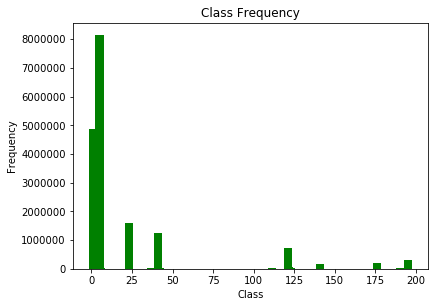

In [14]:
def read_label(label_raster_path):
    with rasterio.open(label_raster_path) as label:
        label_arr=label.read(1)
    return label_arr
label_arr=read_label('Rasters/cdl_new.tif')
def read_raster_data(raster_data_path):
    with rasterio.open(raster_data_path) as rast_data:
        rast_data_arr=rast_data.read()
        rast_data_arr=rast_data_arr.reshape((rast_data_arr.shape[1],rast_data_arr.shape[2],rast_data_arr.shape[0]))
    return rast_data_arr
rast_data=read_raster_data('Rasters/new1.tif')
print(rast_data.shape)
print(label_arr.shape)
unique, counts = np.unique(label_arr, return_counts=True)
class_count=dict(zip(unique,counts))
print(class_count)

sorted(class_count.items(),key=lambda x: x[1])
#unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, width=5.0, color='g')
plt.plot(scalex=True)
plt.tight_layout()
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

In [3]:
print(rast_data.shape) # the rapideye satellite image data
print(label_arr.shape) # NASS cropland cover label data

(4373, 4021, 5)
(4373, 4021)


# Importing NDVI & Sliding Window Analysis Regression Layers

In [4]:
ndvi=slidingWindowAnalysis.ndvi_analysis('Rasters/new1.tif',window_size=2,agg_func='sum')
regression=slidingWindowAnalysis.regression_analysis('Rasters/new1.tif',window_size=2,agg_func='sum')

In [22]:
def generates_datasets(sample_size):
    X=np.array(['green','blue','red','nir','red_edge','ndvi','regression'])
    Y=np.array(['class_label'])
    for i in range(sample_size):
        x_cord=np.random.randint(3000)
        y_cord=np.random.randint(3000)
        row=list(rast_data[x_cord,y_cord])
        row.append(ndvi[x_cord,y_cord])
        row.append(regression[x_cord,y_cord])
        
        X=np.vstack([X,row])
        Y=np.vstack([Y,label_arr[x_cord,y_cord]])
    return X,Y


  

# SKlearn Classification Algorithims 

In [23]:
from sklearn.metrics import confusion_matrix 
from sklearn.cross_validation import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn import linear_model

In [24]:
def splitdataset(X,Y): 
    # Spliting the dataset into train and test 
    X_train, X_test, y_train, y_test = train_test_split(  
    X, Y, test_size = 0.3, random_state = 100) 
      
    return X_train, X_test, y_train, y_test 

In [25]:
def splitdatasetKfold(X,Y): 
    kf=StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    kf.get_n_splits(X)
  
    # Seperating the target variable 
    #X = X[1:, :5] 
    #Y = Y[1:, :] 
   
    # Spliting the dataset into train and test 
    for train_index, test_index in kf.split(X):
        #print(“TRAIN:”, train_index, “TEST:”, test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
    return X_train, X_test, y_train, y_test 

In [26]:
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test) 
    print("Predicted values:") 
    print(y_pred) 
    return y_pred 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred))

In [27]:
SAMPLE_SIZE=10000
X,Y=generates_datasets(SAMPLE_SIZE)

In [28]:
def cal_score_and_prediction(pipeline,cv,X_sel,Y_sel):
    #cv = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    scores = cross_val_score(pipeline, X_sel,Y_sel, cv = cv.get_n_splits())
    print ("Cross-validated scores:", scores)
    predictions=cross_validation.cross_val_predict(pipeline, X_sel,Y_sel, cv=cv.get_n_splits())
    cal_accuracy(Y_sel,predictions)
     


In [29]:
from sklearn.grid_search import GridSearchCV
def grid_search(clf,cv,X_sel,Y_sel,parameter_grid):
    #cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=cv.get_n_splits())
    grid_search.fit(X_sel,Y_sel)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    clf = grid_search.best_estimator_
    print(clf)

In [34]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from yellowbrick.model_selection import ValidationCurve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
def classifier_score_plots(pipeline,clf,cv,X_sel,Y_sel,parameter_grid):
    #cv_scores = cross_val_score(clf, X[1:,:], Y.ravel()[1:,], cv=10)
    #cv = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    #roc curve 
    #predictions=cross_validation.cross_val_predict(pipeline, X_sel,Y_sel, cv=cv.get_n_splits())
    # precision recall curve
    #X_train,X_test,y_train_y_test=splitdatasetKfold(X_sel,Y_sel)
    
    #Validtion Curve
    param_name=list(parameter_grid.keys())[0]
    print(param_name)
    param_range=list(parameter_grid.values())[0]
    train_scores, test_scores = validation_curve(clf, 
                                                 X_sel,Y_sel, param_name=param_name, param_range=param_range,cv=cv.get_n_splits(), 
                                                 scoring="f1_weighted", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel("{}".format(param_name))
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    plt.figure()
    plt.title("Learning Curve")
    plt.ylim(0.0, 1.1)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X_sel, Y_sel, cv=cv, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
def classifier_run(clf,parameter_grid,scalar=None,feature_importance=False):
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])
    print('......................................................................................')
    print("Sliding Window Analaysis layers included....")
    print('......................................................................................')
    print("with StratifiedKFold.....")
    X_sel,Y_sel=X[1:,:],Y.ravel()[1:,]
    cal_score_and_prediction(pipeline,cv,X_sel,Y_sel)
    classifier_score_plots(pipeline,clf,cv,scalar.fit_transform(X[1:,:]) if scalar else X_sel,Y_sel,parameter_grid)
    #grid_search(clf,cv,scalar.fit_transform(X[1:,:]) if scalar else X_sel,Y_sel,parameter_grid)
    if feature_importance:
        forest=clf
        forest.fit(X_sel,Y_sel)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::-1]

        # Print the feature ranking
        print("Feature ranking:")

        for f in range(X.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

        # Plot the feature importances of the forest
        plt.figure()
        plt.title("Feature importances")
        plt.bar(range(X.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
        plt.xticks(range(X.shape[1]), indices)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    print('......................................................................................')
    print("Sliding Window Analaysis layers not included....")
    print('......................................................................................')
    print("with StratifiedKFold.....")
    X_sel,Y_sel=X[1:,:5],Y.ravel()[1:,]
    cal_score_and_prediction(pipeline,cv,X_sel,Y_sel)
    classifier_score_plots(pipeline,clf,cv,scalar.fit_transform(X[1:,:]) if scalar else X_sel,Y_sel,parameter_grid)
    #grid_search(clf,cv,scalar.fit_transform(X[1:,:]) if scalar else X_sel,Y_sel,parameter_grid)

# Support Vector Machine 

SVM with rbf Kernel
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.58603491  0.59090909  0.5955      0.58408408  0.58997494]
Confusion Matrix:  [[1407    0    0    0    0    0    0    0    0    0   17    0    0    1
  1142    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  91    0    0    0    0    0    0    0    0    0   85    0    0    1
   201    0]
 [   2    0    0    0    0    0    0    0    0    0    6    0    0    0
    12    0]
 [   0    0    0    0    0    0    0    0    0    0    9    0    0    0
     2    0]
 [  25    0    0    0    0    0    0    0    0    0    3    0    0    0
    62    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  74    0    0    0    0    0    

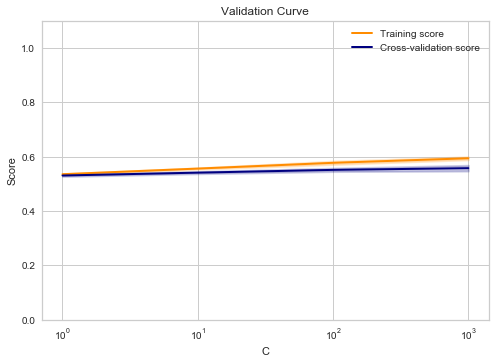

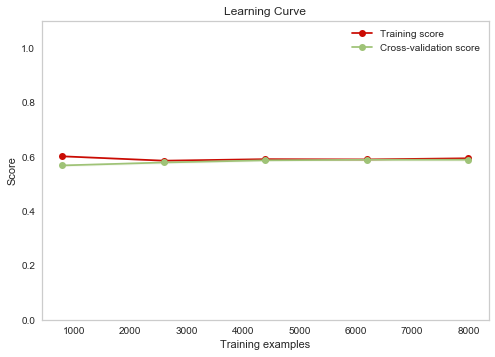

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.46683292  0.46753247  0.468       0.46846847  0.46917293]
Confusion Matrix:  [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  2567    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     5    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
   378    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    20    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    11    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    90    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [   0    0    0    0    0    0    0    0    0    0

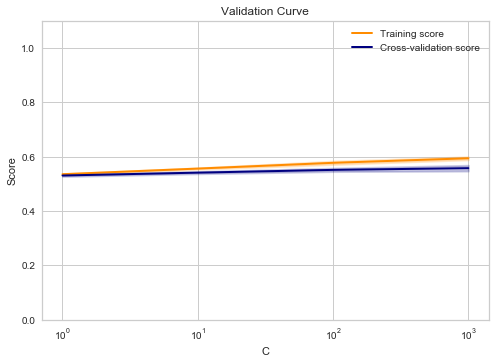

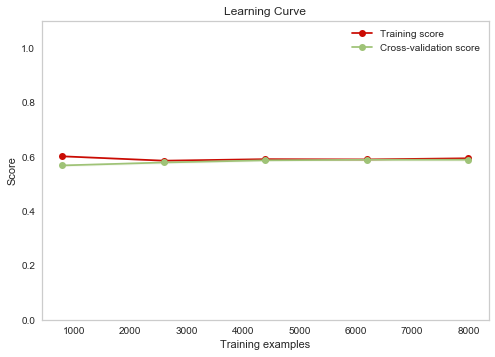

In [36]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scalar = StandardScaler()
clf = svm.SVC()
print('SVM with rbf Kernel')
parameter_grid2={'C': [1, 10, 100, 1000],'kernel': ['rbf'] 
                     ,'gamma': [1e-3, 1e-4]}
classifier_run(clf,parameter_grid2,scalar)


SVM with Linear Kernel
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.58603491  0.59090909  0.5955      0.58408408  0.58997494]
Confusion Matrix:  [[1407    0    0    0    0    0    0    0    0    0   17    0    0    1
  1142    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  91    0    0    0    0    0    0    0    0    0   85    0    0    1
   201    0]
 [   2    0    0    0    0    0    0    0    0    0    6    0    0    0
    12    0]
 [   0    0    0    0    0    0    0    0    0    0    9    0    0    0
     2    0]
 [  25    0    0    0    0    0    0    0    0    0    3    0    0    0
    62    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  74    0    0    0    0    0 

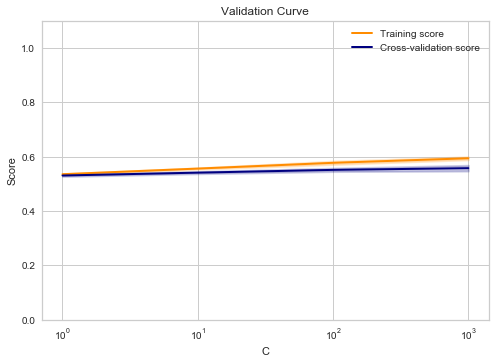

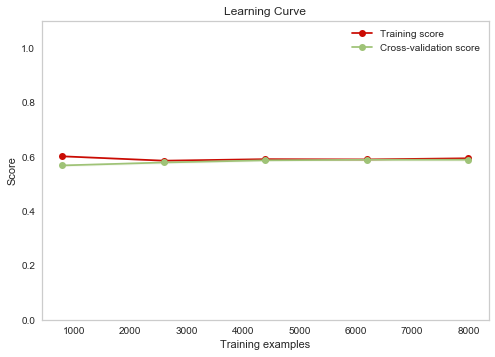

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.46683292  0.46753247  0.468       0.46846847  0.46917293]
Confusion Matrix:  [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  2567    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     5    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
   378    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    20    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    11    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    90    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [   0    0    0    0    0    0    0    0    0    0

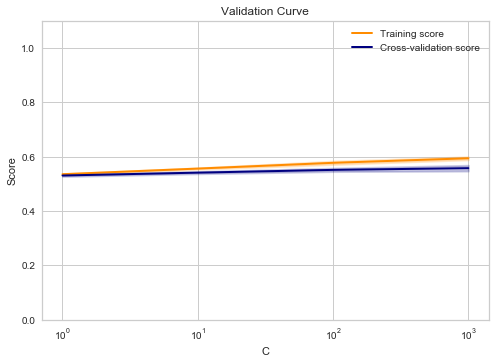

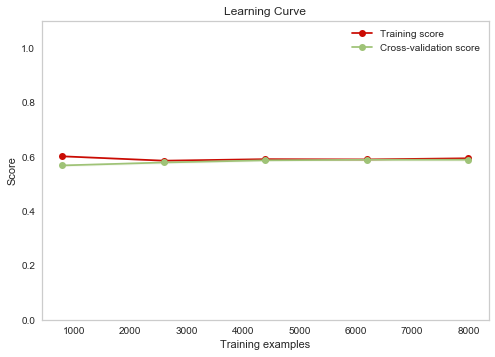

In [37]:
print('SVM with Linear Kernel')
parameter_grid={'C': [1, 10, 100, 1000],'kernel': ['linear']}
classifier_run(clf,parameter_grid,scalar)


# KNeighborsClassifier

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])
with scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.5127182   0.52497502  0.536       0.52752753  0.52330827]
Confusion Matrix:  [[1598    0   27    0    0    5    0   16    3   12   14    0    0   21
   871    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     4    0]
 [ 103    0   33    3    1    0    0    2    0    4   57    0    0    3
   172    0]
 [   3    0    2    0    0    0    0    0    0    0    4    0    0    0
    11    0]
 [   0    0    2    0    0    0    0    0    0    0    6    0    0    0
     3    0]
 [  34    0    4    0    0    0    0    0    0    2    3    0    0    2
    45    0]
 [   0    0    0    

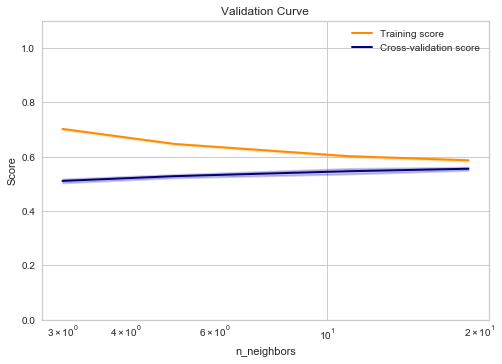

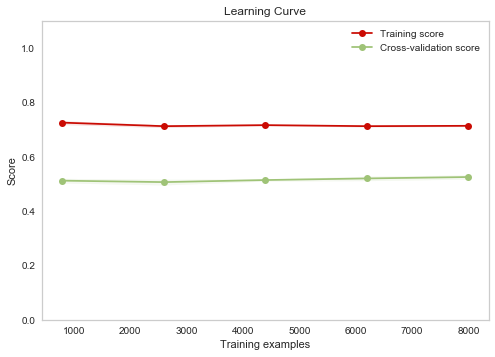

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.32169576  0.34415584  0.33        0.32782783  0.33333333]
Confusion Matrix:  [[1046    0   76    4    1   18    0   35    4   24  137    0    5   46
  1171    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    0]
 [ 145    1   11    1    0    2    0    5    4    2   26    0    1    3
   177    0]
 [   8    0    2    0    0    0    0    0    0    0    0    0    0    0
    10    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     8    0]
 [  32    0    6    0    0    1    0    3    0    0    7    0    0    1
    40    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  75    0    6    0    0    3    0    1    1    2

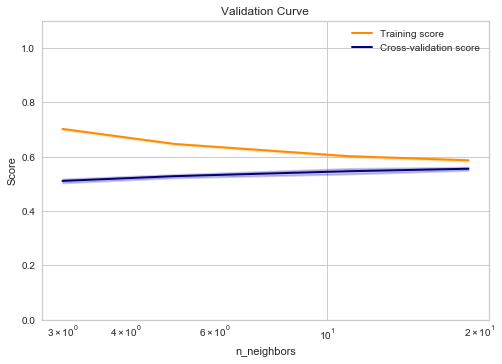

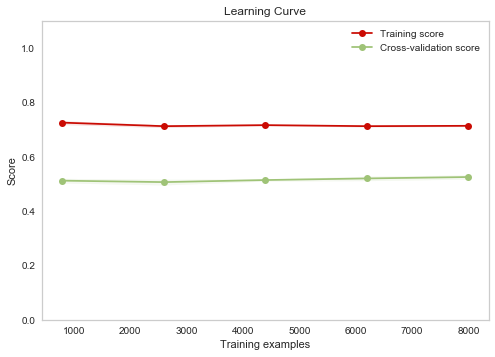

without scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.32269327  0.34365634  0.3285      0.32782783  0.32982456]
Confusion Matrix:  [[1043    0   78    4    1   18    0   36    4   25  136    0    4   46
  1172    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    0]
 [ 147    1   11    1    0    2    0    5    4    1   26    0    1    3
   176    0]
 [   8    0    2    0    0    0    0    0    0    0    0    0    0    0
    10    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     8    0]
 [  33    0    6    0    0    1    0    2    0    0    7    0    0    1
    40    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  73    0    6    0    0    3    0  

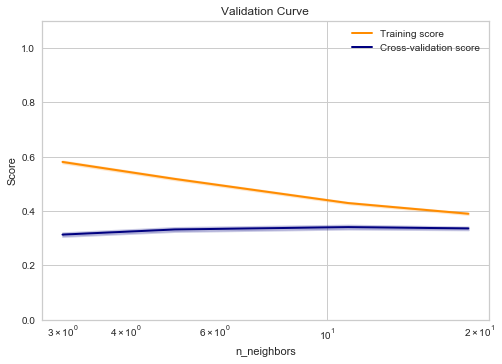

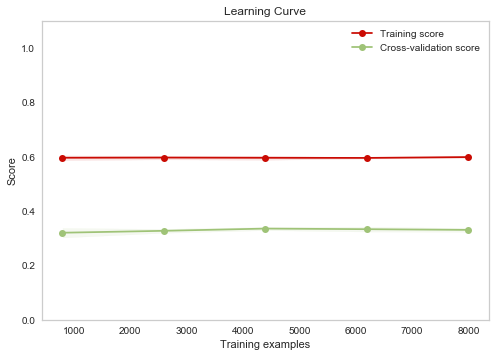

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.32269327  0.34365634  0.3285      0.32832833  0.32982456]
Confusion Matrix:  [[1043    0   78    4    1   18    0   36    4   25  136    0    4   46
  1172    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    0]
 [ 147    1   11    1    0    2    0    5    4    1   26    0    1    3
   176    0]
 [   8    0    2    0    0    0    0    0    0    0    0    0    0    0
    10    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     8    0]
 [  33    0    6    0    0    1    0    2    0    0    7    0    0    1
    40    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  73    0    6    0    0    3    0    1    1    2

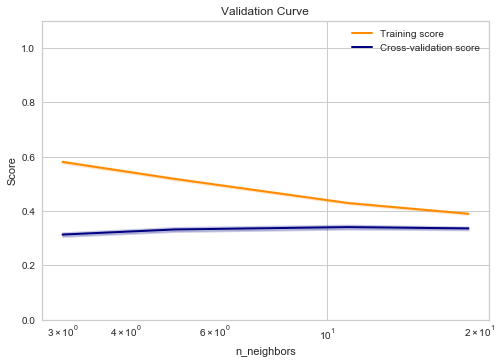

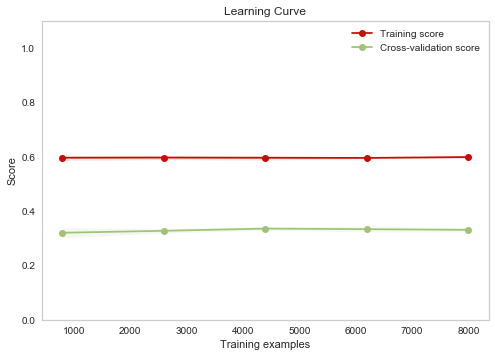

In [38]:
from sklearn.neighbors import KNeighborsClassifier

scalar = StandardScaler()
clf =  KNeighborsClassifier(n_neighbors=3)
parameter_grid={'n_neighbors':[3,5,11,19],
                'weights':['uniform','distance'],
                'metric':['euclidean', 'l2', 'l1', 'manhattan']}
classifier_run(clf,parameter_grid,scalar)


print('without scalaing')
classifier_run(clf,parameter_grid)
#grid_search(clf,X_sel,Y_sel,parameter_grid2)


# RandomForestClassifier

with scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.54912718  0.55794206  0.566       0.55455455  0.54837093]
Confusion Matrix:  [[1617    0   15    0    0    0    0    6    0    7   17    0    1   22
   882    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  97    0   12    0    0    3    0    4    1    2   76    0    2    8
   173    0]
 [   1    0    0    0    0    1    0    0    0    0    6    0    0    0
    12    0]
 [   0    0    0    0    1    0    0    0    0    0    8    0    0    0
     2    0]
 [  28    0    1    0    0    0    0    0    0    0    2    0    0    2
    57    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  69    0    3    0    0    0    0    5

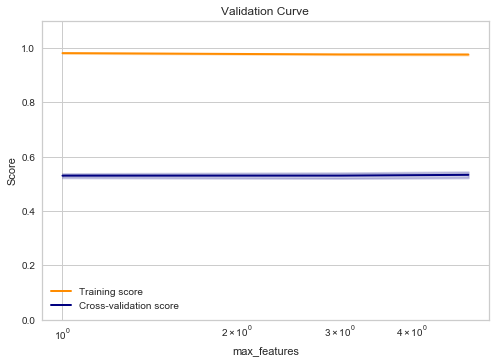

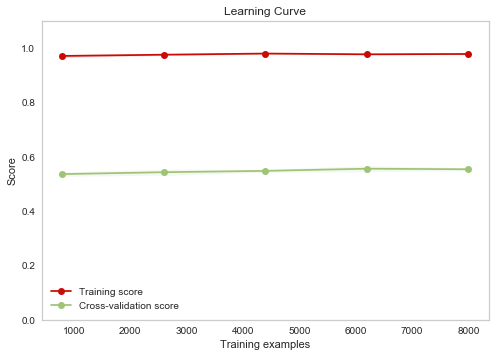

Feature ranking:
1. feature 5 (0.250194)
2. feature 6 (0.192794)
3. feature 0 (0.114715)
4. feature 2 (0.111815)
5. feature 3 (0.110932)
6. feature 4 (0.110031)
7. feature 1 (0.109519)


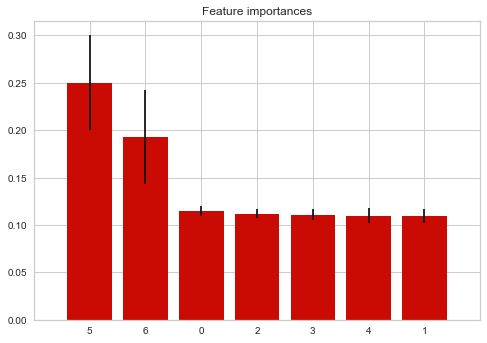

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.38304239  0.38161838  0.374       0.39239239  0.38145363]
Confusion Matrix:  [[ 751    1   27    0    0    3    0    8    2   10  120    0    2   86
  1557    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     4    0]
 [ 117    0    6    0    0    1    0    1    0    1   13    0    1   13
   225    0]
 [   7    0    0    0    0    0    0    0    0    0    1    0    0    1
    11    0]
 [   3    0    0    0    0    0    0    0    0    0    1    0    0    1
     6    0]
 [  27    0    2    0    0    0    0    1    0    0    3    0    0    3
    54    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  57    0    4    0    0    0    0    0    0    1

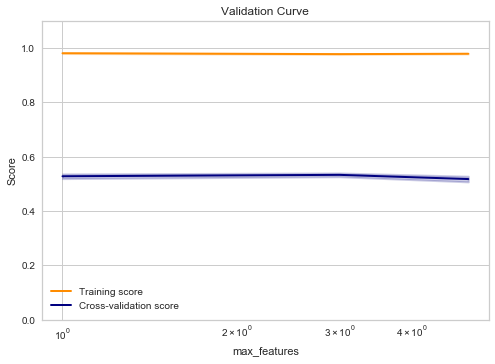

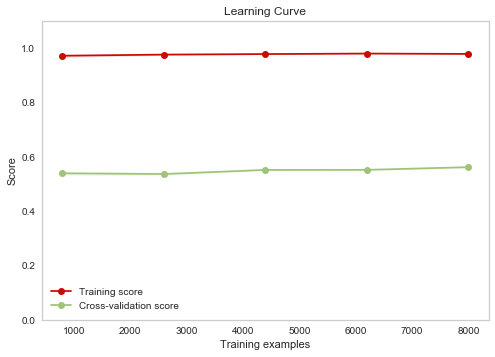

without scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.54613466  0.56293706  0.541       0.56606607  0.53634085]
Confusion Matrix:  [[1590    1   19    1    0    4    0    6    1    4   19    0    4   20
   898    0]
 [   1    0    1    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  98    0   16    0    0    0    0    2    1    6   80    0    0    3
   172    0]
 [   3    0    2    0    0    0    0    0    0    0    4    0    0    0
    11    0]
 [   0    0    1    0    1    0    0    0    0    0    7    0    0    0
     2    0]
 [  33    0    1    0    0    0    0    0    0    0    2    0    0    2
    52    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  57    0    3    0    0    0    0  

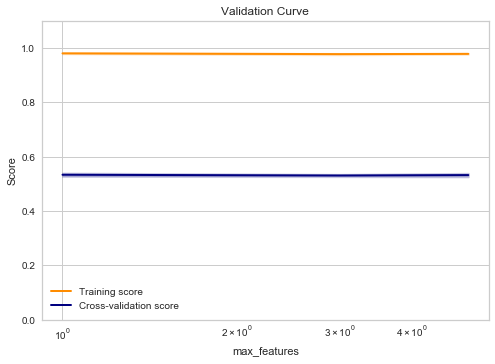

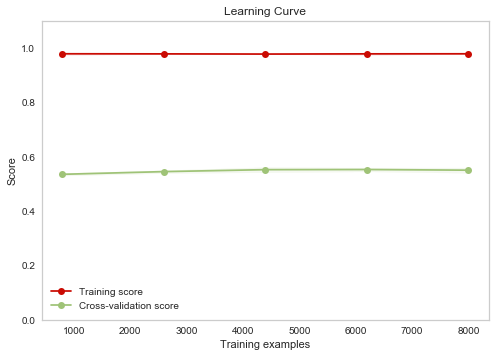

Feature ranking:
1. feature 6 (0.224307)
2. feature 5 (0.218255)
3. feature 0 (0.113181)
4. feature 4 (0.111711)
5. feature 2 (0.111430)
6. feature 1 (0.110690)
7. feature 3 (0.110427)


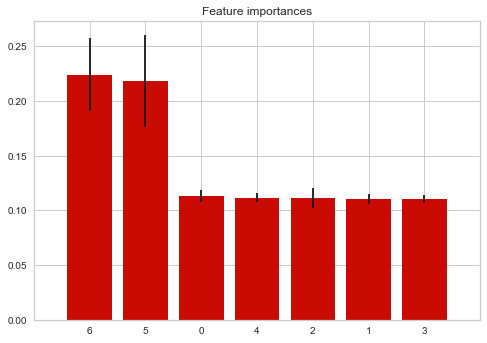

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.3680798   0.38611389  0.3815      0.37887888  0.37343358]
Confusion Matrix:  [[ 738    0   27    1    0    5    0    5    2   12  121    0    1   98
  1557    0]
 [   1    0    0    0    0    0    0    0    0    0    1    0    0    0
     3    0]
 [ 110    0    4    0    0    1    0    0    0    0   12    0    0   10
   241    0]
 [   6    0    0    0    0    0    0    0    0    0    0    0    0    1
    13    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     8    0]
 [  28    0    1    0    0    1    0    0    0    0    4    0    0    4
    52    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  61    0    0    0    0    0    0    1    0    0

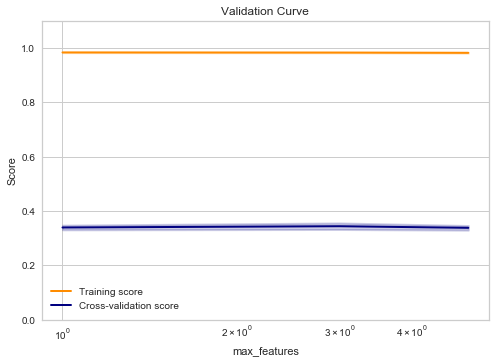

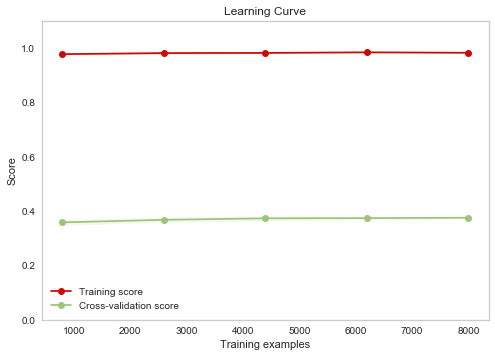

In [39]:
from sklearn.ensemble import RandomForestClassifier

scalar = StandardScaler()
clf = RandomForestClassifier(n_estimators=10)
parameter_grid = {"max_features": [1, 3, 5 or 7 ],
                  "max_depth": [1, 2, 3, 4, 5],
                  "min_samples_split": [2, 3, 10],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
classifier_run(clf,parameter_grid,scalar,feature_importance=True)


print('without scalaing')
classifier_run(clf,parameter_grid,feature_importance=True)
#grid_search(clf,X_sel,Y_sel,parameter_grid2)


# DecisionTreeClassifier

with scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.44837905  0.47052947  0.4465      0.47147147  0.44260652]
Confusion Matrix:  [[1213    3   81    3    1   35    0   52    6   54   19    0    7   82
  1007    4]
 [   2    0    1    0    0    0    0    0    0    0    0    0    0    0
     2    0]
 [  78    0   37    4    0    1    0   10    2    8   60    0    5   11
   162    0]
 [   2    0    0    0    0    0    0    1    0    0    4    0    0    0
    13    0]
 [   0    0    1    0    1    0    0    1    0    0    3    0    0    0
     5    0]
 [  27    0    3    0    0    2    0    3    1    0    1    1    0    6
    45    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  50    0   11    0    0    2    0    7

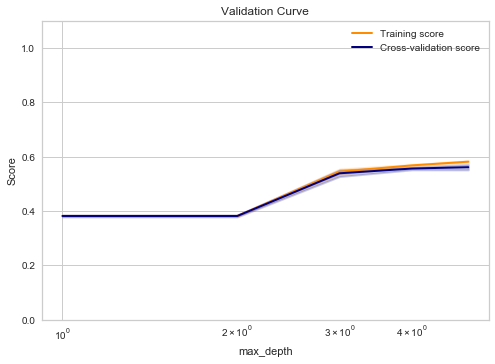

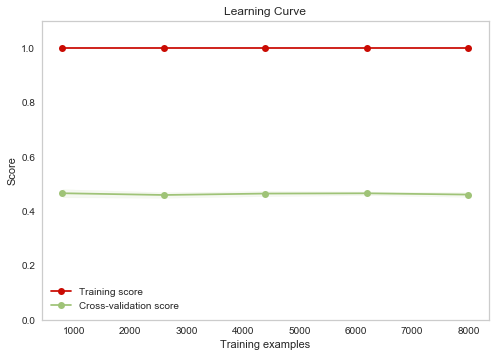

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.30024938  0.2952048   0.31        0.2952953   0.2952381 ]
Confusion Matrix:  [[ 648    2  113    5    3   21    1   48    5   51  266    1   11  232
  1152    8]
 [   2    0    0    0    0    0    0    0    0    0    1    0    0    1
     1    0]
 [  93    0   17    0    0    4    0    8    1    3   31    0    2   31
   187    1]
 [   5    0    0    0    0    0    0    0    0    0    3    0    0    3
     9    0]
 [   3    0    0    0    0    0    0    0    0    0    1    0    0    2
     5    0]
 [  19    0    3    0    0    3    0    2    1    2    9    0    1    4
    46    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  41    0    3    1    0    2    0    1    0    7

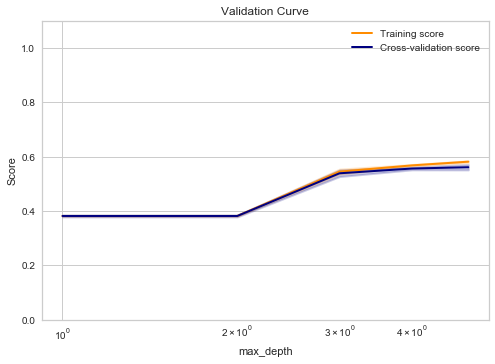

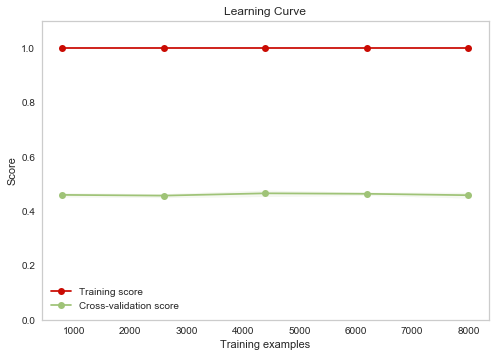

without scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.45187032  0.46553447  0.4605      0.46446446  0.45213033]
Confusion Matrix:  [[1207    3   75    6    1   44    1   46    8   59   22    0    6   78
  1008    3]
 [   0    0    1    0    0    0    0    0    0    0    0    0    0    0
     4    0]
 [  83    1   32    1    0    2    0   10    4    8   64    0    4   11
   158    0]
 [   2    0    0    0    0    0    0    1    0    0    4    0    0    1
    12    0]
 [   0    0    1    0    1    0    0    0    0    0    4    0    0    0
     5    0]
 [  30    0    3    0    0    2    0    1    1    0    1    1    0    7
    44    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  49    0   10    0    0    1    0  

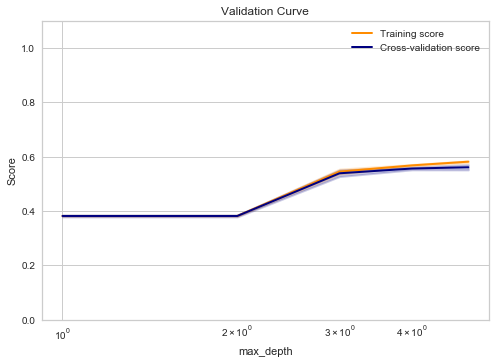

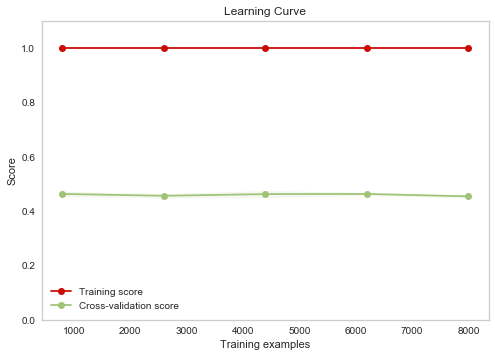

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.29226933  0.29220779  0.307       0.28978979  0.29674185]
Confusion Matrix:  [[ 657    1  102    5    4   28    1   51    4   41  274    1    5  228
  1158    7]
 [   2    0    1    0    0    0    0    0    0    0    1    0    0    0
     1    0]
 [  96    0   15    0    0    3    0    6    1    2   36    0    3   33
   182    1]
 [   5    0    0    0    0    0    0    1    0    0    2    0    0    2
    10    0]
 [   4    0    0    0    0    0    0    0    0    0    0    0    0    1
     6    0]
 [  18    0    3    0    0    1    0    3    0    1    8    0    2    8
    46    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  40    0    4    1    0    5    0    0    0    5

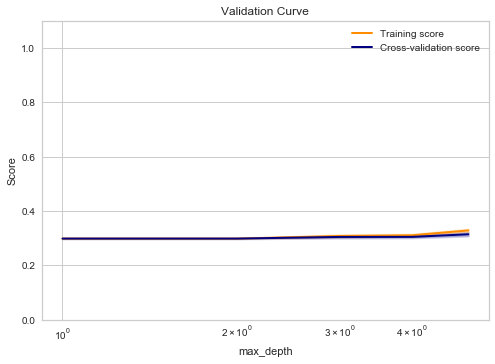

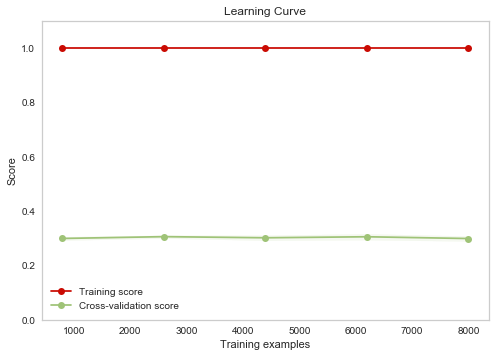

In [40]:
from sklearn.tree import DecisionTreeClassifier

scalar = StandardScaler()
clf = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_features': [1, 2, 3, 4]}
classifier_run(clf,parameter_grid,scalar)


print('without scalaing')
classifier_run(clf,parameter_grid)
#grid_search(clf,X_sel,Y_sel,parameter_grid2)


# ExtraTreesClassifier

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
with scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.53266833  0.55244755  0.5555      0.56806807  0.54736842]
Confusion Matrix:  [[1539    0   28    0    0    2    0   11    0    9   16    0    0   22
   940    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  91    0   15    1    1    0    0    2    0    3   73    0    1    5
   186    0]
 [   3    0    1    0    0    0    0    0    0    0    4    0    0    0
    12    0]

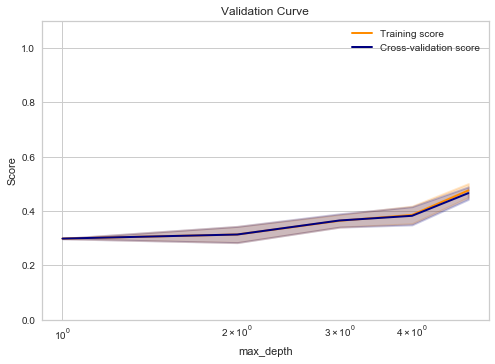

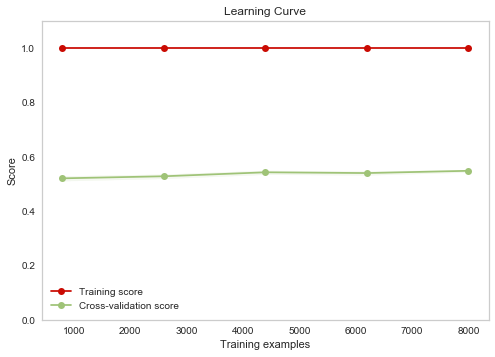

Feature ranking:
1. feature 6 (0.240467)
2. feature 5 (0.207084)
3. feature 1 (0.112331)
4. feature 0 (0.110605)
5. feature 4 (0.110264)
6. feature 2 (0.109669)
7. feature 3 (0.109580)


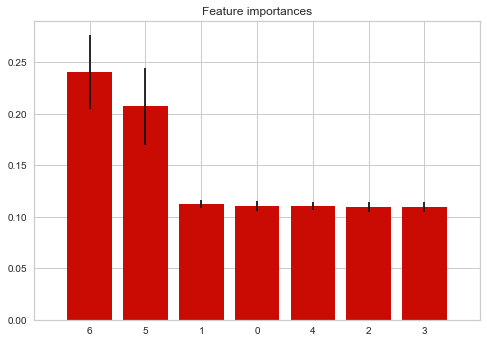

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.36957606  0.36963037  0.3495      0.37787788  0.37694236]
Confusion Matrix:  [[ 742    0   30    2    0    5    0   10    0    8  134    0    0  113
  1522    1]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     4    0]
 [ 105    0    7    0    0    1    0    1    0    2   22    0    0   13
   227    0]
 [   6    0    0    0    0    0    0    0    0    0    2    0    0    0
    12    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     8    0]
 [  27    0    2    0    0    0    0    1    0    1    6    0    0    0
    53    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  49    0    2    0    0    0    0    0    0    0

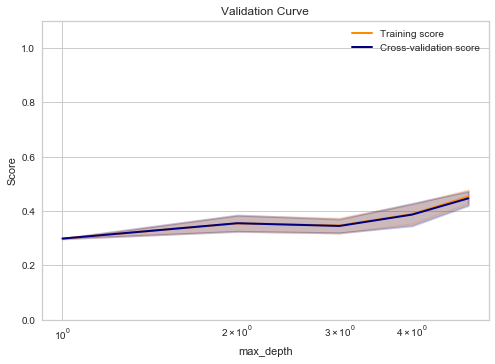

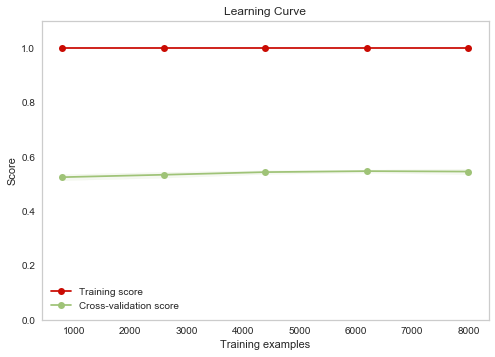

without scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.53316708  0.54645355  0.552       0.55805806  0.53734336]
Confusion Matrix:  [[1563    0   25    0    0    4    0   15    0    7   24    0    1   26
   902    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     2    0]
 [  99    0   16    1    1    0    0    4    1    4   74    0    0    7
   171    0]
 [   1    0    0    0    0    0    0    0    0    0    5    0    0    0
    14    0]
 [   0    0    1    0    1    0    0    0    0    0    5    0    0    0
     4    0]
 [  28    0    1    0    0    0    0    0    0    0    2    0    0    1
    57    1]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  66    0    4    0    0    0    0  

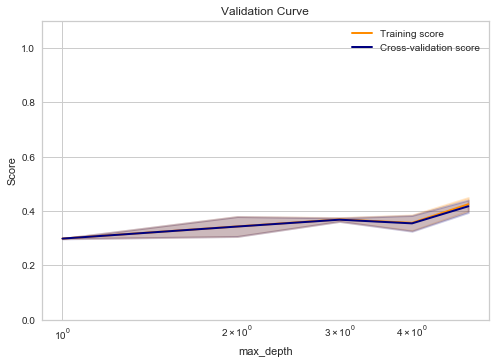

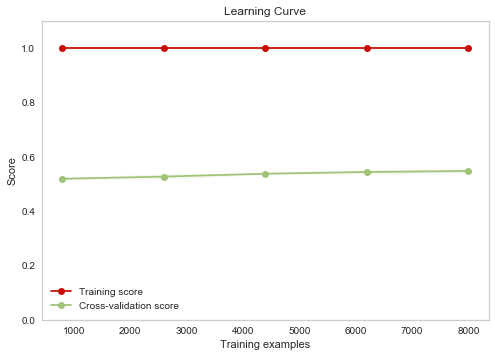

Feature ranking:
1. feature 5 (0.224179)
2. feature 6 (0.219153)
3. feature 4 (0.113680)
4. feature 1 (0.112170)
5. feature 2 (0.110331)
6. feature 0 (0.110326)
7. feature 3 (0.110161)


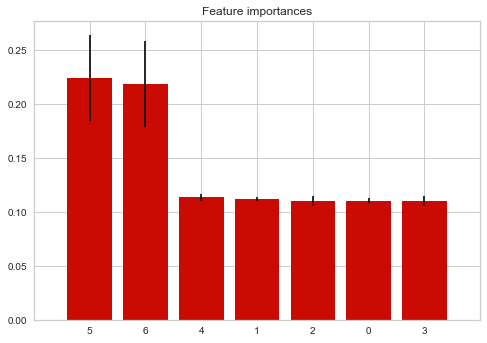

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.37007481  0.36963037  0.3805      0.38738739  0.37192982]
Confusion Matrix:  [[ 756    0   38    1    1    8    0   13    2    8  126    0    1  100
  1511    2]
 [   4    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [  98    0    5    0    0    1    0    3    0    0   24    0    0   15
   232    0]
 [   8    0    0    0    0    0    0    0    0    0    1    0    0    0
    11    0]
 [   3    0    0    0    0    0    0    0    0    0    0    0    0    0
     8    0]
 [  22    0    2    0    0    0    0    0    0    2    5    0    0    3
    56    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  47    0    1    0    0    2    0    1    0    0

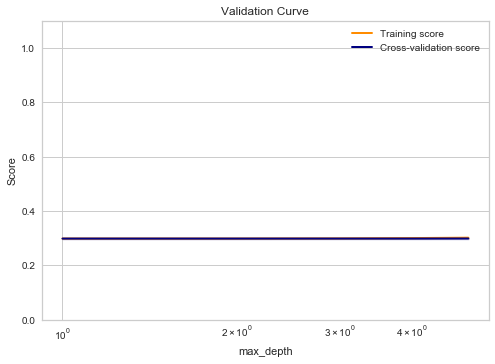

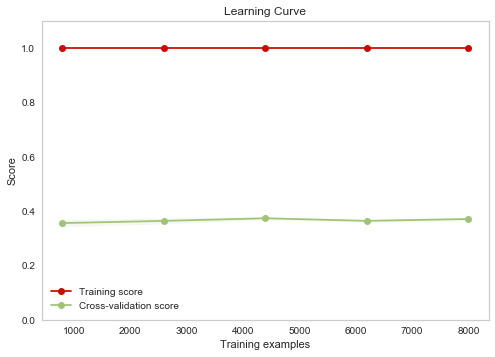

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

scalar = StandardScaler()
clf = ExtraTreesClassifier()
print(clf.get_params().keys())
parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_features': [1, 2, 3, 4]}
classifier_run(clf,parameter_grid,scalar,feature_importance=True)


print('without scalaing')
classifier_run(clf,parameter_grid,feature_importance=True)
#grid_search(clf,X_sel,Y_sel,parameter_grid2)


# GradientBoostingClassifier

with scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.56658354  0.58491508  0.583       0.58958959  0.58897243]
Confusion Matrix:  [[1735    0    9    2    0   11    0   11    1   12   27    1    3   11
   742    2]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  91    0    1    0    1    0    0    3    0    0   79    0    0    6
   197    0]
 [   3    0    0    0    0    0    0    0    0    0    5    0    0    1
    11    0]
 [   0    0    0    0    2    0    0    1    0    0    6    0    0    0
     2    0]
 [  28    0    0    0    0    0    0    0    0    0    3    0    0    0
    59    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  61    0    0    0    0    1    0    0

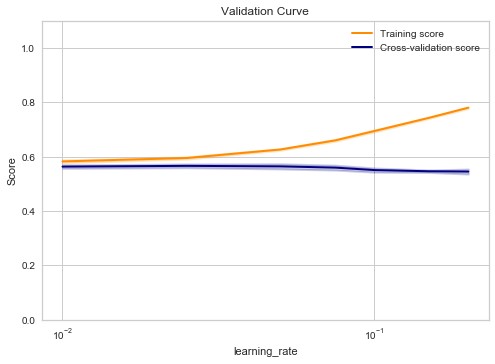

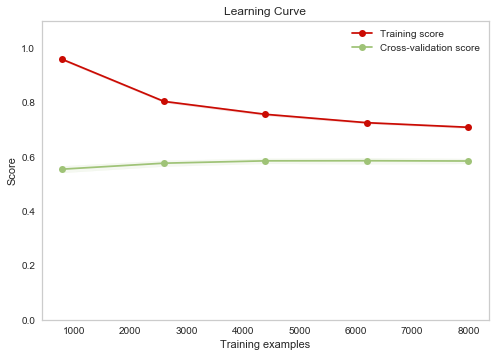

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.45286783  0.45154845  0.4485      0.44344344  0.4406015 ]
Confusion Matrix:  [[  90    0    9    3    0    9    0   14    5    9   10    0    4   18
  2392    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     5    0]
 [  14    0    0    0    2    1    0    1    0    3    3    0    1    0
   353    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
    19    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     9    0]
 [   3    0    0    0    0    0    0    1    0    0    0    0    1    1
    84    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [   7    0    0    0    1    0    0    3    1    1

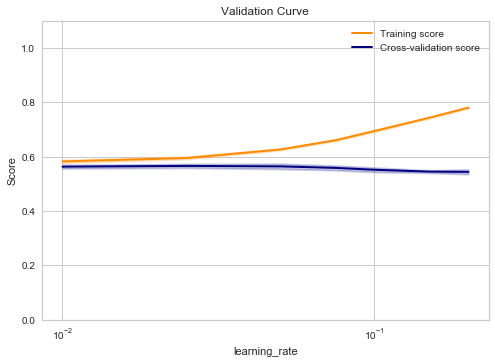

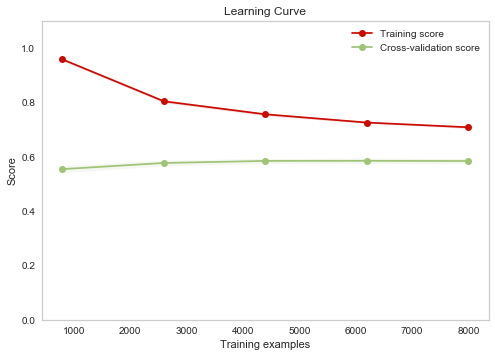

without scalaing
......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.56558603  0.58891109  0.5825      0.58908909  0.58345865]
Confusion Matrix:  [[1736    0    9    1    0   12    0    9    1   13   26    1    3   12
   742    2]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  93    0    1    0    1    1    0    3    0    1   79    0    0    6
   193    0]
 [   3    0    0    0    0    0    0    0    0    0    5    0    0    1
    11    0]
 [   0    0    0    0    2    0    0    1    0    0    6    0    0    0
     2    0]
 [  28    0    0    0    0    0    0    0    0    0    3    0    0    0
    59    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  60    0    0    0    0    1    0  

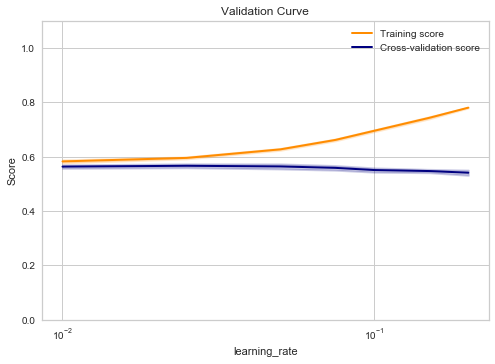

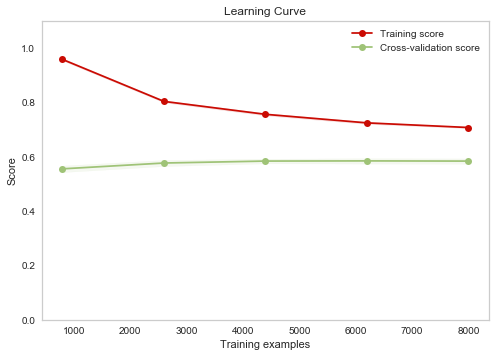

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.45336658  0.45254745  0.4535      0.44544545  0.44160401]
Confusion Matrix:  [[  94    0    9    1    0    7    0   13    5    9   12    0    3   17
  2393    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     5    0]
 [  12    0    2    0    2    3    0    3    0    2    3    0    1    0
   350    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
    19    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
    10    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    1    1
    86    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [   7    0    0    0    1    0    0    2    0    1

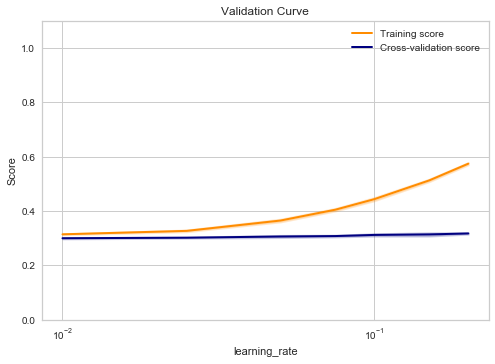

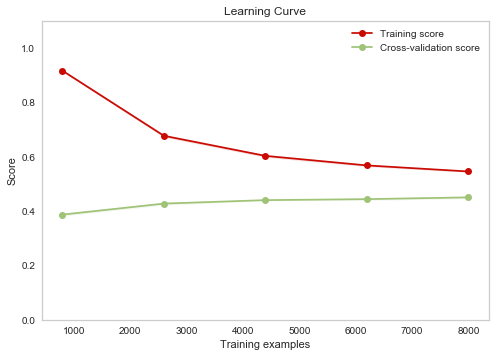

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

scalar = StandardScaler()
clf=GradientBoostingClassifier()
parameter_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "loss":["deviance"],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }
classifier_run(clf,parameter_grid,scalar)


print('without scalaing')
classifier_run(clf,parameter_grid)
#grid_search(clf,X_sel,Y_sel,parameter_grid2)


# MLP

......................................................................................
Sliding Window Analaysis layers included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.59201995  0.60589411  0.613       0.60560561  0.61152882]
Confusion Matrix:  [[1769    0    0    0    0    0    0    0    0    0   12    0    0    4
   782    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     3    0]
 [  86    0    0    0    0    0    0    0    0    0   70    0    0    1
   221    0]
 [   3    0    0    0    0    0    0    0    0    0    5    0    0    0
    12    0]
 [   0    0    0    0    0    0    0    0    0    0    8    0    0    0
     3    0]
 [  29    0    0    0    0    0    0    0    0    0    3    0    0    0
    58    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  63    0    0    0    0    0    0    0    0    0    

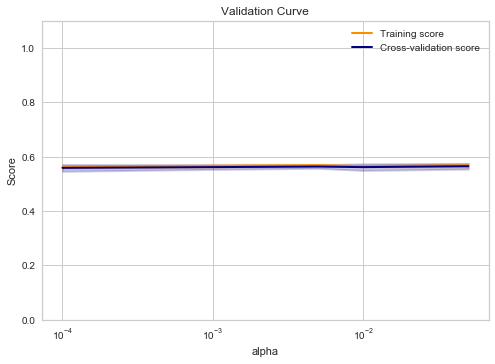

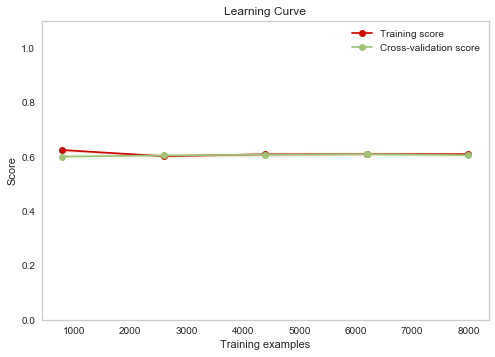

......................................................................................
Sliding Window Analaysis layers not included....
......................................................................................
with StratifiedKFold.....
Cross-validated scores: [ 0.46733167  0.46753247  0.467       0.46796797  0.46967419]
Confusion Matrix:  [[   4    0    0    0    0    0    0    0    0    0    0    0    0    0
  2563    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     5    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
   378    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    20    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    11    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    90    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1    0]
 [   0    0    0    0    0    0    0    0    0    0

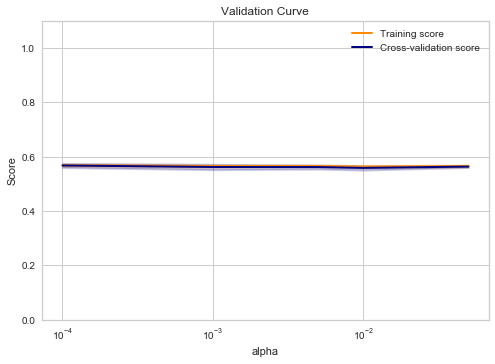

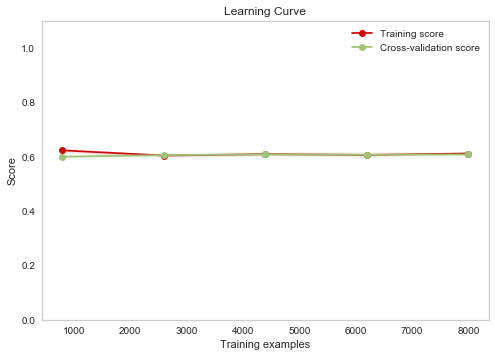

Best score: 0.6096
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [43]:
from sklearn.neural_network import MLPClassifier
scalar = StandardScaler()
clf = MLPClassifier(max_iter=100)
parameter_grid = {
     'alpha': [0.0001,0.001,0.005,0.01,0.05],
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}

classifier_run(clf,parameter_grid,scalar)

cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
grid_search(clf,cv,scalar.fit_transform(X[1:,:]),Y.ravel()[1:,],parameter_grid)